In [2]:
%pylab notebook

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

import primo.models
import primo.datasets
import primo.tools.sequences as seqtools

from copy import deepcopy

from primo.models.cas9_keras import log10_crispr_spec, log10_norm_crispr_spec, linear_crispr_spec

from primo.models.encoder import entropy_regularizer

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-iy7h31t8 because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib
1 Physical GPUs, 1 Logical GPUs


In [3]:
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=10**5
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    # TODO: Verify with Callie this understanding is correct https://github.com/uwmisl/cas9-similarity-search/issues/2
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by enumerating all the images in the dataset (before splitting them into test/train/validate datasets)
        # pairs:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar

# To see how this value was derived, please consult the Materials and Methods subsection under Feature Extraction section.
similarity_threshold = 75
# Intuitively determined:
batch_size = 150
val_batch_size = 150

train_batch_generator = keras_batch_generator(
    train_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)

val_batch_generator = keras_batch_generator(
    validation_dataset.balanced_pairs(val_batch_size, similarity_threshold),
    similarity_threshold
)
        
train_inputs, train_targets = next(train_batch_generator)

switching to train_d.h5 and train_0.h5


In [21]:
def make_multisite_predictor(predictor):
    """Return a function that will predict multiple sites using the predictor
    function provided to score each
    
    Combined probability is 1 - (1 - P(site1)) * (1 - P(site2)) ... * (1 - P(siteN))
    """
    def multisite_predict(seq_pairs):
        n_sites = int(seq_pairs.shape[2] / 20)
        # Split into separate sites
        sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
        # Apply predictor to sites independently
        scores = tf.map_fn(tf.function(predictor), sites)
        #scores *= tf.sqrt(tf.reduce_mean(tf.reduce_max(seq_pairs, axis=-1)))
        # Compute combined probability|
        #return tf.reduce_max(scores, axis=0)
        #return 2 * (tf.sigmoid(3*tf.sqrt(tf.reduce_sum(scores, axis=0))) - 0.5)
        return 1 - tf.reduce_prod(1 - scores, axis=0)

    return multisite_predict

def log_multisite_predictor(seq_pairs):
    n_sites = int(seq_pairs.shape[2] / 20)
    # Split into separate sites
    sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
    # Apply predictor to sites independently
    scores = tf.map_fn(tf.function(log10_crispr_spec), sites)
    return tf.reduce_max(scores, axis=0)
        
subpen = np.array([-1.7449405080809126, -1.275485084790358, -1.8001827224086722, -1.9323849500279549, -1.6677722398632207, -1.6537370694565101, -1.8981469677400609, -1.0814292717607923, -1.3231152511430453, -0.99840146446464273, -1.2766126030502924, -1.073338813454068, -1.5614374592181826, -1.4737507320504855, -1.298392565410591, -1.0105000195452765, -0.43349702574711524, -0.11665543376814178, -0.17370266801790191, 0.2676084623705467, 0.051835157750172757, 0.08920809165894289, 0.075459598643889569, 0.046975071077932237]).astype(np.float32)
subpen = subpen[:20][::-1]
    
def dotproduct_crispr_spec(seq_pairs):
    ref, _ = tf.linalg.normalize(seq_pairs[:, 0, :, :], axis=-1)
    obs, _ = tf.linalg.normalize(seq_pairs[:, 1, :, :], axis=-1)
    
    # 1 - Dot product
    x = 1 -  tf.reduce_sum(ref*obs, axis=-1)
    scores = tf.reduce_sum(x * tf.constant(subpen.flatten(), dtype=tf.float32), -1)
    return scores

def dotproduct_linearized(mid_point=None):
    """Returns a predictor function which will scale the log10 scores such that the
    given `mid_point` value is 0.5.
    
    mid_point is the output of log10_crispr_spec, and shoudl be on range [log10_lb, log10_ub]
    
    If mid_point is none, cleave rate is linearized; i.e. return 10**log_10_crispr_spec(x)
    """
    power = 10
    if mid_point is not None:
        power = 0.5 ** (1 / mid_point)

    def f(seq_pairs):
        """
        seq_pairs batch_size x 2 x SEQLEN x 4
        """
        scores = power ** dotproduct_crispr_spec(seq_pairs)
        confidence = tf.reduce_mean(tf.reduce_max(seq_pairs, -1), axis=2)
        confidence = tf.reduce_prod(confidence, axis=1)
        return 0.5 + (scores - 0.5) * confidence

    return f

In [22]:
OUTPUT_LEN = 100

# Chooses k in linear_score = k ** log10_score, such that linear_score is 0.5
# when log10_score is equal to the KNEE value.
# A value of -0.301 yields linear_score = 10**log10_score. 
SCORE_LINEARIZER_KNEE = -1.5

TRAIN_PREDICTOR = tf.function(make_multisite_predictor(dotproduct_linearized(SCORE_LINEARIZER_KNEE)))
REAL_PREDICTOR = tf.function(make_multisite_predictor(linear_crispr_spec(SCORE_LINEARIZER_KNEE)))

# encoder = tf.keras.Sequential([
#     layers.Dense(2048, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0001)),
#     layers.Dropout(0.2),
#     layers.Dense(1024, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0001)),
#     layers.Dropout(0.2),
#     layers.Dense(OUTPUT_LEN * 4, activation='relu'),
#     layers.Reshape([OUTPUT_LEN, 4]),
#     layers.Activation('softmax'),
#     layers.Lambda(
#         # Just using the identity because we don't want to transform the softmaxxed output,
#         # we just want to make sure we learn an output encoding that's regularized (i.e. not crazy complex/over-fitting)
#         lambda x: x,

#         # In inference mode, this does nothing (just passes identity), but when training, this regularizes
#         # the activations.
#         # Using an "entropy" regulator because we passed the output through a softmax.
#         activity_regularizer=entropy_regularizer(
#             0.000
#         )
#     )
# ], name='encoder')


encoder = tf.keras.models.load_model('/tf/primo/data/models/encoder_5site_1.h5')

# from primo.models.encoder import ClusteringLayer
# import pickle
# with open('/tf/primo/data/clusters_kmeans_64.pkl', 'rb') as f:
#     kmodel = pickle.loads(f.read())
# kmeans = kmodel.cluster_centers_
# encoder = tf.keras.Sequential([
#     ClusteringLayer(kmeans.shape[0], kmeans, input_dim=4096, alpha=25.0),
#     layers.Dense(1024, activation = 'relu'),
#     layers.Dense(OUTPUT_LEN * 4, activation='relu'),
#     layers.Reshape([OUTPUT_LEN, 4]),
#     layers.Activation('softmax'),
# ], name='encoder')

X_pairs = layers.Input([2, 4096])

# Essentially, we started with ]a batch of feature-vector pairs...
# ...And turned them into a pair of feature-vector batches.
X1, X2 = layers.Lambda(lambda X: (X[:,0,:], X[:,1,:]))(X_pairs)

distances = layers.Lambda(lambda Xs: tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[1]), axis=1)))([X1,X2])

# Independently transforms the batches of feature vectors into soft-max encoded DNA sequences.
S1 = encoder(X1)
S2 = encoder(X2)

# Glue them back together! Back into a batch of feature vector pairs.
S_pairs = layers.Lambda(
    lambda Ss: tf.stack(Ss, axis=-1)
)([S1,S2])

# Dimensions: (batch_size x 80 x 4 x 2 ) (i.e. batch size x DNA length x # of nucleotides x 2)

# Swaps dimensions for the predictor, which wants (batch-size x 2 x DNA length x 4)
S_pairs_T = layers.Lambda(lambda S: tf.transpose(S, [0, 3, 1, 2]))(S_pairs)

# y_h: Estimated output
y_h = layers.Lambda(TRAIN_PREDICTOR)(S_pairs_T)
y_h_T = layers.Reshape([1])(y_h)

S_pairs_T_OH = tf.one_hot(K.argmax(S_pairs_T, -1), 4)
y_h_OH = layers.Lambda(REAL_PREDICTOR)(S_pairs_T_OH)
y_h_t_OH = layers.Reshape([1])(y_h_OH)
y_h_t_OH = layers.Reshape([1])(y_h_OH)
y_h_OH_log = layers.Lambda(tf.function(log_multisite_predictor))(S_pairs_T_OH)

calcseq = tf.keras.Model(inputs=X_pairs, outputs=S_pairs_T)
calcdists = tf.keras.Model(inputs=X_pairs, outputs=distances)
encoder_trainer = tf.keras.Model(inputs=X_pairs, outputs=y_h_T)
onehotseqs = tf.keras.Model(inputs=X_pairs, outputs=S_pairs_T_OH)
onehotscore = tf.keras.Model(inputs=X_pairs, outputs=y_h_t_OH)
onehotscore_log = tf.keras.Model(inputs=X_pairs, outputs=y_h_OH_log)

print(encoder.summary())

# Initialize with previously trained weights
#encoder.load_weights('/tf/primo/data/models/encoder_3site_4.h5')
# from keras.utils.vis_utils import plot_model
# plot_model(encoder_trainer, show_shapes=True, show_layer_names=True)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 400)               410000    
_________________________________________________________________
reshape_9 (Reshape)          (None, 100, 4)            0         
_________________________________________________________________
activation_3 (Activation)    (None, 100, 4)            0   

In [6]:
import secrets
import os

def confidence_by_base(sequences):
    """Takes a batch of softmax sequences, and returns vector of average confidence in each position
    
    sequences: Number of exmaple x Number of bases x 4
    
    Returns: 1 x number of bases
    """
    # reduce last dimension to max base number
    return np.mean(np.max(sequences, axis=-1), axis=0)

def entropy_by_base(sequences):
    x = np.sum(sequences, axis=0)
    x /= np.sum(x, axis=1)[:, None]
    entropy = -np.sum(x * np.log(x + 1e-10), axis=1)
    return entropy

def one_hot(nparray, depth = 0, on_value = 1, off_value = 0):
    if depth == 0:
        depth = np.max(nparray) + 1
    assert np.max(nparray) < depth, "the max index of nparray: {} is larger than depth: {}".format(np.max(nparray), depth)
    shape = nparray.shape
    out = np.ones((*shape, depth)) * off_value
    indices = []
    for i in range(nparray.ndim):
        tiles = [1] * nparray.ndim
        s = [1] * nparray.ndim
        s[i] = -1
        r = np.arange(shape[i]).reshape(s)
        if i > 0:
            tiles[i-1] = shape[i-1]
            r = np.tile(r, tiles)
        indices.append(r)
    indices.append(nparray)
    out[tuple(indices)] = on_value
    return out

def UniquenessMetric(y_true, y_pred):
    """Use a single batch of inputs to measure sequence uniqueness while training"""
    seqs = calcseq(train_inputs)
    # Reduce seqs to a single base (e.g. [0.6, 0.2, 0.1, 0.1] -> [0])
    rounded_seqs = K.argmax(seqs[:, 0, :, :], axis=-1)
    # Now each sample is array of 20 integers, 0-3. Multiply each position by 4**n to make
    # a unique integer for each possible 20bp sequence
    unique_seqs = np.unique(K.get_value(rounded_seqs), axis=0)
    #hashed_seqs = tf.reduce_sum(rounded_seqs * (4 ** tf.range(0, 20, dtype=tf.int64)), axis=-1)
    # Get unique ones
    #unique_seqs, _ = tf.unique(hashed_seqs)
    # Return ratio of unique to input
    return float(len(unique_seqs)) / len(train_inputs)

def ConfidenceMetric(batch):
    """Uses a single batch of inputs to measure sequence uniqueness while training"""
    def confidence(_y_true, _y_pred):
        seqs = calcseq(batch)
        # Get the highest probabilty value for each base
        max_seqs = tf.reduce_max(seqs, axis=-1)
        # Take mean along both batch and seqence dimensions
        return tf.reduce_mean(max_seqs)
    return confidence

class EarlyStopCallback(keras.callbacks.Callback):
    def __init__(self, **kwargs):
        uid = secrets.token_hex(2)
        self.__file = f'/tf/primo/signals/{uid}'
        print(f"Touch {self.__file} to terminate training early")
        super().__init__(**kwargs)

    def on_epoch_end(self, epoch, logs={}):
        if os.path.exists(self.__file):
          print (f"\nStopping after Epoch {epoch}")
          self.model.stop_training = True

class EntropyLoggerCallback(keras.callbacks.Callback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.confidence = []
        self.entropy = []
        self.oh_entropy = []
    
    def on_epoch_end(self, epoch, logs={}):
        seqs_softmax = calcseq.predict(train_inputs)[:, 0, :, :]
        seqs_onehot = one_hot(seqs_softmax.argmax(-1))
        
        self.oh_entropy.append(entropy_by_base(seqs_onehot))
        self.confidence.append(confidence_by_base(seqs_softmax))
        self.entropy.append(entropy_by_base(seqs_softmax))
        
    

In [13]:
encoder_trainer.compile(
    tf.keras.optimizers.Adagrad(1e-1),
    'binary_crossentropy',
    run_eagerly=True,
    metrics=[
        UniquenessMetric,
        ConfidenceMetric(train_inputs),
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(),
        'accuracy'])
history = encoder_trainer.fit(
    train_batch_generator,
    validation_data=val_batch_generator,
    validation_steps=5,
    steps_per_epoch=500,
    epochs=100,
    callbacks=[EarlyStopCallback()],
)

Touch /tf/primo/signals/cd3c to terminate training early
Epoch 1/100
500/500 [==============================] - 63s 125ms/step - loss: 0.5843 - UniquenessMetric: 0.9958 - confidence: 0.8777 - precision_2: 0.7398 - recall_2: 0.9430 - accuracy: 0.8055 - val_loss: 0.5883 - val_UniquenessMetric: 1.0000 - val_confidence: 0.8961 - val_precision_2: 0.8221 - val_recall_2: 0.9120 - val_accuracy: 0.8573
Epoch 2/100
500/500 [==============================] - 73s 147ms/step - loss: 0.5600 - UniquenessMetric: 0.9922 - confidence: 0.8868 - precision_2: 0.7550 - recall_2: 0.9299 - accuracy: 0.8140 - val_loss: 0.5648 - val_UniquenessMetric: 0.9933 - val_confidence: 0.8902 - val_precision_2: 0.8186 - val_recall_2: 0.9147 - val_accuracy: 0.8560
Epoch 3/100
500/500 [==============================] - 74s 148ms/step - loss: 0.5429 - UniquenessMetric: 0.9929 - confidence: 0.8932 - precision_2: 0.7650 - recall_2: 0.9209 - accuracy: 0.8189 - val_loss: 0.5591 - val_UniquenessMetric: 0.9933 - val_confidence: 0.

500/500 [==============================] - 50s 99ms/step - loss: 0.4832 - UniquenessMetric: 0.9729 - confidence: 0.9491 - precision_2: 0.8239 - recall_2: 0.8489 - accuracy: 0.8338 - val_loss: 0.5409 - val_UniquenessMetric: 0.9800 - val_confidence: 0.9503 - val_precision_2: 0.8812 - val_recall_2: 0.7158 - val_accuracy: 0.8107
Epoch 48/100
500/500 [==============================] - 50s 99ms/step - loss: 0.4811 - UniquenessMetric: 0.9670 - confidence: 0.9477 - precision_2: 0.8263 - recall_2: 0.8519 - accuracy: 0.8366 - val_loss: 0.4752 - val_UniquenessMetric: 0.9667 - val_confidence: 0.9492 - val_precision_2: 0.9085 - val_recall_2: 0.7947 - val_accuracy: 0.8573
Epoch 49/100
500/500 [==============================] - 50s 99ms/step - loss: 0.4831 - UniquenessMetric: 0.9651 - confidence: 0.9485 - precision_2: 0.8268 - recall_2: 0.8503 - accuracy: 0.8363 - val_loss: 0.5452 - val_UniquenessMetric: 0.9733 - val_confidence: 0.9503 - val_precision_2: 0.8562 - val_recall_2: 0.6968 - val_accuracy: 

500/500 [==============================] - 50s 99ms/step - loss: 0.4842 - UniquenessMetric: 0.9456 - confidence: 0.9535 - precision_2: 0.8257 - recall_2: 0.8451 - accuracy: 0.8333 - val_loss: 0.4597 - val_UniquenessMetric: 0.9467 - val_confidence: 0.9503 - val_precision_2: 0.9159 - val_recall_2: 0.8155 - val_accuracy: 0.8707
Epoch 94/100
500/500 [==============================] - 49s 99ms/step - loss: 0.4911 - UniquenessMetric: 0.9473 - confidence: 0.9518 - precision_2: 0.8198 - recall_2: 0.8435 - accuracy: 0.8292 - val_loss: 0.5110 - val_UniquenessMetric: 0.9267 - val_confidence: 0.9526 - val_precision_2: 0.9024 - val_recall_2: 0.7185 - val_accuracy: 0.8213
Epoch 95/100
500/500 [==============================] - 49s 99ms/step - loss: 0.4826 - UniquenessMetric: 0.9461 - confidence: 0.9513 - precision_2: 0.8268 - recall_2: 0.8471 - accuracy: 0.8348 - val_loss: 0.4951 - val_UniquenessMetric: 0.9533 - val_confidence: 0.9534 - val_precision_2: 0.8951 - val_recall_2: 0.7261 - val_accuracy: 

In [19]:
encoder_trainer.compile(tf.keras.optimizers.Adagrad(1e-2), 'binary_crossentropy')
history = encoder_trainer.fit(train_inputs, train_targets, epochs=200)

Epoch 1/200
5/5 [==============================] - 1s 12ms/step - loss: 2.0765
Epoch 2/200
5/5 [==============================] - 0s 12ms/step - loss: 1.9972
Epoch 3/200
5/5 [==============================] - 0s 12ms/step - loss: 1.9363
Epoch 4/200
5/5 [==============================] - 0s 12ms/step - loss: 1.8837
Epoch 5/200
5/5 [==============================] - 0s 11ms/step - loss: 1.8404
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 1.7950
Epoch 7/200
5/5 [==============================] - 0s 11ms/step - loss: 1.7506
Epoch 8/200
5/5 [==============================] - 0s 11ms/step - loss: 1.7135
Epoch 9/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6733
Epoch 10/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6309
Epoch 11/200
5/5 [==============================] - 0s 11ms/step - loss: 1.5903
Epoch 12/200
5/5 [==============================] - 0s 11ms/step - loss: 1.5598
Epoch 13/200
5/5 [==============================]

In [18]:
encoder.save('/tf/primo/data/models/encoder_5site_x.h5')

<IPython.core.display.Javascript object>


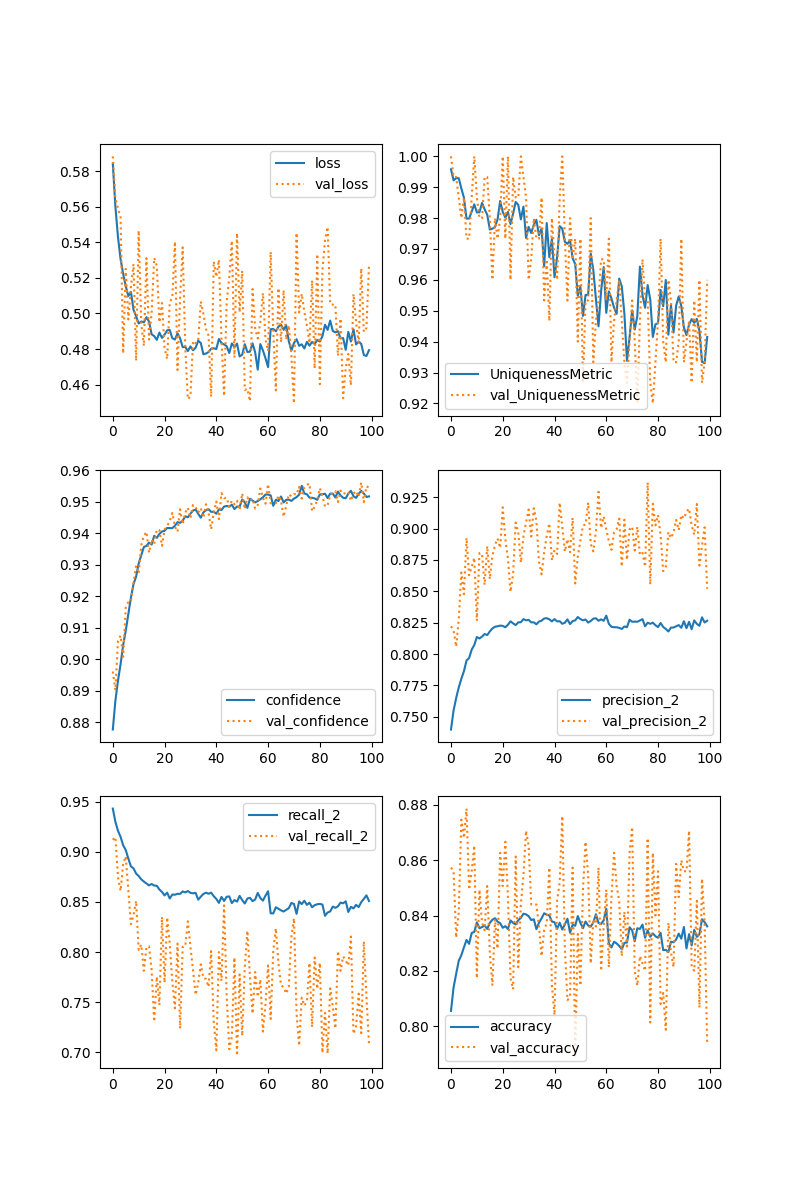

In [14]:
fig = plt.figure(figsize=(8, 12))
lines = [k for k in history.history.keys() if not k.startswith('val_')]

axes = fig.subplots(int(len(lines)/2), 2).flatten()
for i in range(len(lines)):
    label = lines[i]
    try:
        ax = axes[i]
    except TypeError:
        ax = axes
    
    val_label = 'val_' + label

    ax.plot(history.history[label], label=label)
    if val_label in history.history:
        ax.plot(history.history[val_label], linestyle=':', label=val_label)
    ax.legend()

    

<IPython.core.display.Javascript object>


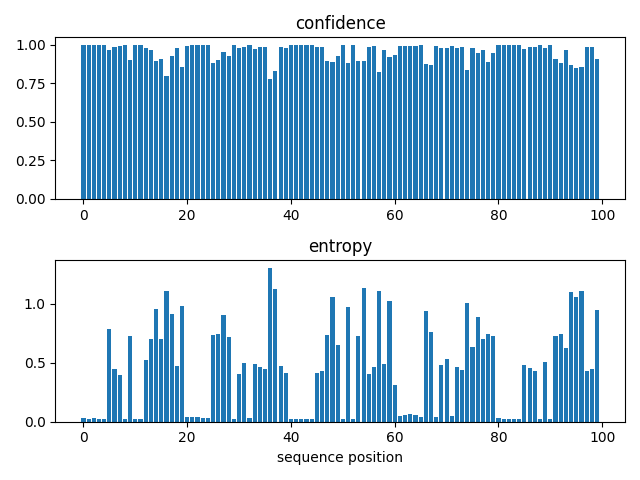

In [13]:
def confidence_by_base(sequences):
    """Takes a batch of softmax sequences, and returns vector of average confidence in each position
    
    sequences: Number of exmaple x Number of bases x 4
    
    Returns: 1 x number of bases
    """
    # reduce last dimension to max base number
    return np.mean(np.max(sequences, axis=-1), axis=0)

def entropy_by_base(sequences):
    x = np.sum(sequences, axis=0)
    x /= np.sum(x, axis=1)[:, None]
    entropy = -np.sum(x * np.log(x + 1e-10), axis=1)
    return entropy

def one_hot(nparray, depth = 0, on_value = 1, off_value = 0):
    if depth == 0:
        depth = np.max(nparray) + 1
    assert np.max(nparray) < depth, "the max index of nparray: {} is larger than depth: {}".format(np.max(nparray), depth)
    shape = nparray.shape
    out = np.ones((*shape, depth)) * off_value
    indices = []
    for i in range(nparray.ndim):
        tiles = [1] * nparray.ndim
        s = [1] * nparray.ndim
        s[i] = -1
        r = np.arange(shape[i]).reshape(s)
        if i > 0:
            tiles[i-1] = shape[i-1]
            r = np.tile(r, tiles)
        indices.append(r)
    indices.append(nparray)
    out[tuple(indices)] = on_value
    return out

seqs_softmax = calcseq.predict(train_inputs)[:, 0, :, :]
#seqs_onehot = one_hot(seqs_softmax.argmax(-1))

confidence = confidence_by_base(seqs_softmax)
entropy = entropy_by_base(seqs_softmax)

seqlen = seqs_softmax.shape[1]
fig = plt.figure()
axes = fig.subplots(2,1)
ax = axes[0]
ax.bar(np.arange(0, seqlen), confidence)
ax.set_title('confidence')
ax = axes[1]
ax.bar(np.arange(0, seqlen), entropy)
ax.set_title('entropy')
ax.set_xlabel('sequence position')
plt.tight_layout()

In [125]:
random_seq = np.repeat(np.array([0.9, 0.1, 0.0, 0.0])[:, None], 20, axis=1).T
random_seq
pair = np.repeat(random_seq[None, None, :, :], 2, axis=1)
pair.shapeI honestly
linear_crispr_spec(-0.8)(tf.convert_to_tensor(pair, dtype=tf.float32))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.08753882], dtype=float32)>

<IPython.core.display.Javascript object>


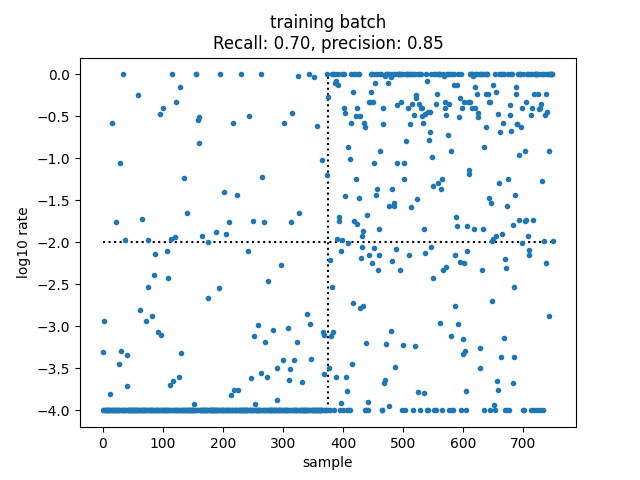

Recall: 0.70, precision: 0.85


<IPython.core.display.Javascript object>


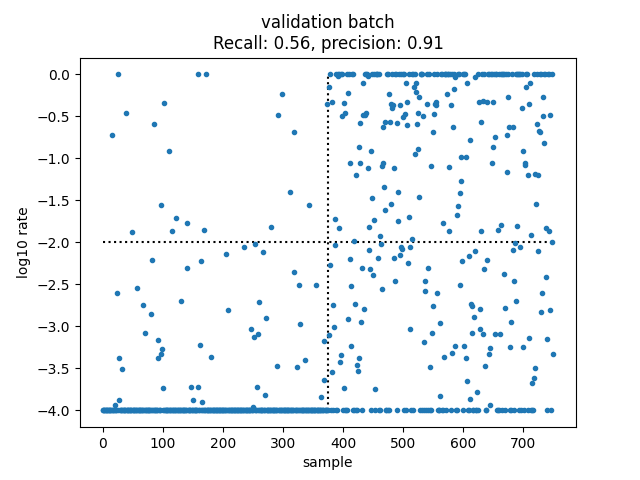

Recall: 0.56, precision: 0.91


In [23]:


def get_batchs(n, generator):
    inputs = None
    target = None
    for _ in range(n):
        i, t = next(generator)
        if inputs is None:
            inputs = i
            targets = t
        else:
            inputs = np.concatenate([inputs, i])
            targets = np.concatenate([targets, t])
    return inputs, targets

def log_batch_results(inputs, targets, title):
    idx = targets.argsort()
    Y = np.maximum(-4.0, onehotscore_log.predict(inputs))

    RECALL_THRESH = -2.0

    recall = ((Y > RECALL_THRESH) * (targets > 0.5)).sum() / (targets > 0.5).sum()
    precision = ((Y > RECALL_THRESH) * (targets > 0.5)).sum() / (Y > RECALL_THRESH).sum()
    plt.figure()
    #plt.plot(val_targets[idx], '.')
    plt.plot(Y[idx], '.')
    plt.hlines(-2.0, 0, len(Y), color='black', linestyle=':')
    plt.vlines(len(inputs) / 2, -4, 0, color='black', linestyle=':')
    plt.ylabel('log10 rate')
    plt.xlabel('sample')
    plt.title(title + f"\nRecall: {recall:.2f}, precision: {precision:.2f}")

    print(f"Recall: {recall:.2f}, precision: {precision:.2f}")

val_inputs, val_targets = get_batchs(5, val_batch_generator)
train_inputs, train_targets = get_batchs(5, train_batch_generator)
log_batch_results(train_inputs, train_targets, 'training batch')
log_batch_results(val_inputs, val_targets, 'validation batch')

<IPython.core.display.Javascript object>


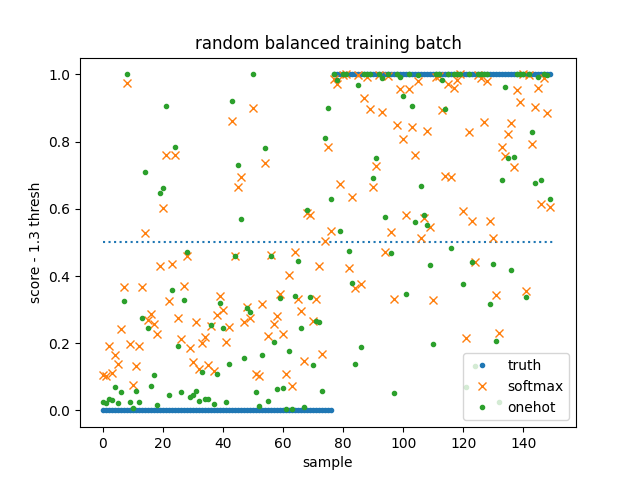

(150,)
(150,)


In [16]:
idx = train_targets.argsort()

Y2 = onehotscore.predict(train_inputs)
Y = encoder_trainer.predict(train_inputs)
seqs = calcseq.predict(train_inputs)
plt.figure()

print(train_targets.shape)
print((Y[:, 0] - train_targets).shape)
plt.plot(train_targets[idx], '.')
plt.plot(Y[idx][:, 0], 'x')
plt.plot(Y2[idx][:, 0], '.')
plt.hlines(0.5, 0, len(seqs), linestyle=':')
plt.ylabel('score - 1.3 thresh')
plt.xlabel('sample')
plt.title('random balanced training batch')
plt.legend(['truth', 'softmax', 'onehot'])

In [6]:
seqs

array([[[[4.31110129e-06, 4.31110129e-06, 9.99987125e-01,
          4.31110129e-06],
         [4.20248534e-06, 4.20248534e-06, 4.20248534e-06,
          9.99987364e-01],
         [4.19611843e-06, 4.19611843e-06, 4.19611843e-06,
          9.99987483e-01],
         ...,
         [1.00000000e+00, 1.33520704e-13, 1.33520704e-13,
          1.33520704e-13],
         [1.41867147e-07, 9.99999642e-01, 1.41867147e-07,
          1.41867147e-07],
         [3.77111246e-05, 9.99945641e-01, 8.34106413e-06,
          8.34106413e-06]],

        [[1.11638933e-07, 1.11638933e-07, 9.99999642e-01,
          1.11638933e-07],
         [1.15118603e-07, 1.15118603e-07, 1.15118603e-07,
          9.99999642e-01],
         [1.13896846e-07, 1.13896846e-07, 1.13896846e-07,
          9.99999642e-01],
         ...,
         [1.00000000e+00, 5.04517116e-14, 5.04517116e-14,
          5.04517116e-14],
         [4.89046306e-06, 9.98764992e-01, 1.22526835e-03,
          4.89046306e-06],
         [9.42652941e-01, 5.7266138

<IPython.core.display.Javascript object>


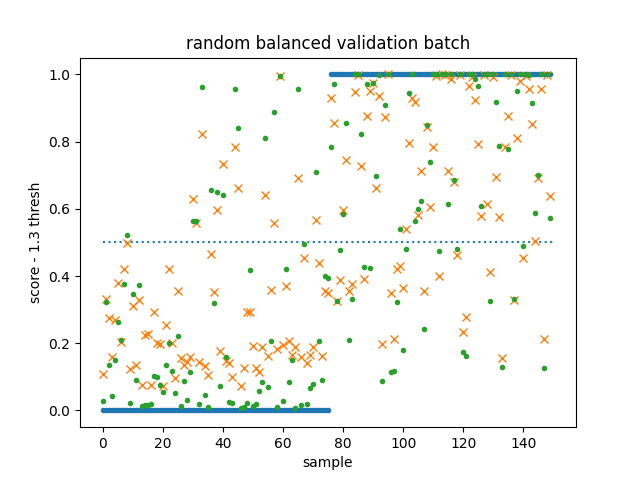

(150,)
(150,)


Text(0.5, 1.0, 'random balanced validation batch')

In [14]:
def get_batchs(n, generator):
    inputs = None
    target = None
    for _ in range(n):
        i, t = next(generator)
        if inputs is None:
            inputs = i
            targets = t
        else:
            inputs = np.concatenate([inputs, i])
            targets = np.concatenate([targets, t])
    return inputs, targets

#val_inputs, val_targets = next(val_batch_generator)
val_inputs, val_targets = get_batchs(1, val_batch_generator)

idx = val_targets.argsort()
Y = encoder_trainer.predict(val_inputs)
Y2 = onehotscore.predict(val_inputs)
plt.figure()

print(val_targets.shape)
print((Y[:, 0] - val_targets).shape)
plt.plot(val_targets[idx], '.')
plt.plot(Y[idx][:, 0], 'x')
plt.plot(Y2[idx][:, 0], '.')
plt.hlines(0.5, 0, len(Y), linestyle=':')
plt.ylabel('score - 1.3 thresh')
plt.xlabel('sample')
plt.title('random balanced validation batch')



<IPython.core.display.Javascript object>


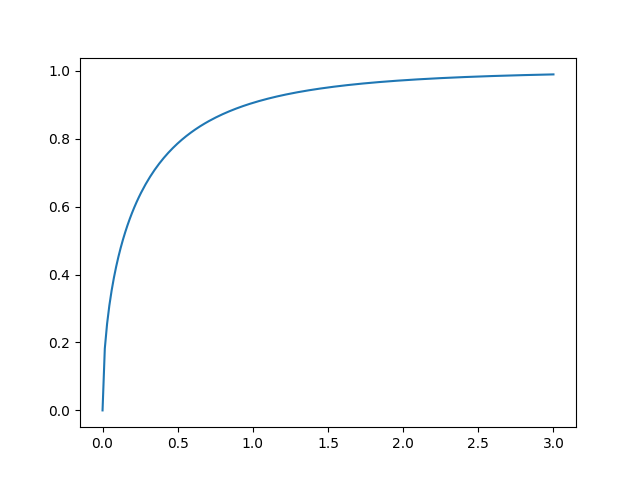

In [51]:
x = np.linspace(0, 3.0, 200)
y = 2 * (tf.sigmoid(3*sqrt(x)) - 0.5)#- tf.math.log(1. / x - 1.)
plt.figure(); plt.plot(x, y)

In [40]:
seqs = calcseq.predict(train_inputs)
all_seqs = seqs[:, 0, :, :] #np.concatenate([seqs[:, 0, :, :], seqs[:, 1, :, :]])

seq_strings = seqtools.onehots_to_seqs(all_seqs)
print(len(np.unique(all_seqs.argmax(-1), axis=0)))
unique = np.unique(seq_strings)
print(unique)
print(f"{len(unique)} / {len(all_seqs)}")



107
['CGGCGAACACAATGCGAACTCTCGGCAGCAGCGTACACGGAACTTGCGGAGCCCACTCTT'
 'CGGCGAACACCATAAATCTACTCGGAAATCGTGTTTACGCAACTTTGGCGGACCACGATA'
 'CGGCGAACACCATAAGTCTACTCGGAAATCGTGTTTGCGGAACTTTGACGGACCACGATT'
 'CGGCGAACACCATGCATCTACTCGGCCATCGTGTTTGCGCAACTTTGGCGGCCGAGTATT'
 'CGGCGAACACCATGCGTCCACTCGGACATAGCGTTTGCGGAACTTTCACGGACGACTATT'
 'CGGCGAACATAATTAATCCACTCGGACATCGCGTTGGGGGAACTTGTACGGACGAGGTCT'
 'CGGCGAACATAGTTAGTCCACTCGGCCATAGCGTTCGGGGAACTTTGACGGACGAGTTCT'
 'CGGCGAACATAGTTCGTACGCTCGGCCATAGCGGGCGGGGAACTTGTAGGGCCGAGTTCT'
 'CGGCGAACATAGTTCGTCCACTCGGCCATAGCGTTCGGGGAACTTTGACGGCCGAGTTCT'
 'CGGCGAACATCATACATCTACTCGGACATCGTGTTTGGGCAACTTTGACGGACGAGGACA'
 'CGGCGAAGATAGTTAATACGCTCGGCGATAGCGGGCGGGGAACTTGTAGGGCCTAGTTCT'
 'CGGCGACCACAATAAATCTACTCGGAAATCGTGTTTACGGAACTTGGGCGGACCACGATT'
 'CGGCGACCACAATAAATCTTCTCGGAAGTCGTGTTGACGCAACTTGCGCGGACCACGACA'
 'CGGCGACCACAATAAATCTTCTCGGACATCGCGTTGACGGAACTTGCGCGGACCACGATT'
 'CGGCGACCACAATAAGACTGCTCGGAAGTAGTGTGGGCGGAACTTGCACGGACCACTTTT'
 'CGGCGACCACAATAAGACTTCTCGGAAGTCGTGT

In [69]:
all_seqs[7]

array([[3.3259562e-01, 2.2246814e-01, 2.2246814e-01, 2.2246814e-01],
       [2.3982550e-01, 2.3982550e-01, 2.5065073e-01, 2.6969826e-01],
       [2.3638621e-01, 2.4142413e-01, 2.4318433e-01, 2.7900538e-01],
       [2.1367773e-01, 3.4356976e-01, 2.1367773e-01, 2.2907479e-01],
       [9.8940629e-01, 1.3364973e-03, 1.3364973e-03, 7.9207430e-03],
       [2.9965704e-05, 2.9965704e-05, 9.9991012e-01, 2.9965704e-05],
       [1.9041627e-05, 1.9041627e-05, 1.9041627e-05, 9.9994290e-01],
       [4.0534575e-05, 9.9987841e-01, 4.0534575e-05, 4.0534575e-05],
       [7.5619275e-05, 9.9977320e-01, 7.5619275e-05, 7.5619275e-05],
       [9.9974197e-01, 8.1249840e-05, 9.5489420e-05, 8.1249840e-05],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [2.3508541e-05, 2.3508541e-05, 9.9992955e-01, 2.3508541e-05],
       [3.7527036e-05, 3.7527036e-05, 3.7527036e-05, 9.9988735e-01],
       [9.9994814e-01, 1.7283641e-05, 1.7283641e-05, 1.7283641e-05],
       [9.9995112e-01, 1.6294385e-

In [9]:
# weights = [tensor for tensor in encoder_trainer.trainable_weights]# if encoder_trainer.get_layer(tensor.name[:-2]).trainable]
# optimizer = encoder_trainer.optimizer
# loss = tf.keras.metrics.BinaryCrossentropy(from_logits=False)(y_h_T, train_targets)
# g = optimizer.get_gradients(loss, weights)

with tf.GradientTape() as tape:
    # Doing the computation in the context of the gradient tape
    # For example computing loss
    pred = encoder_trainer(train_inputs)
    loss = tf.metrics.MSE(train_targets,pred)
    
# Getting the gradient of weight w.r.t loss 
grad = tape.gradient(loss, encoder_trainer.trainable_weights) 
print(grad)
#print([tf.norm(g).numpy() for g in grad])

[<tf.Tensor: shape=(4096, 2048), dtype=float32, numpy=
array([[-0.00668996, -0.00442752, -0.01292114, ..., -0.00297812,
         0.00866672,  0.00046856],
       [-0.014083  , -0.0085131 , -0.01540488, ..., -0.00662993,
         0.01435623,  0.00218737],
       [-0.00739208, -0.00459306, -0.00793888, ..., -0.00424623,
         0.00936238,  0.00140106],
       ...,
       [-0.00707141, -0.0031601 , -0.00536229, ..., -0.00655378,
         0.01212534,  0.0022773 ],
       [-0.01130053, -0.00968682, -0.01601881, ..., -0.00374336,
         0.00950455,  0.00092499],
       [-0.00697468, -0.0061232 , -0.00847617, ..., -0.0014009 ,
         0.00568788,  0.00132537]], dtype=float32)>, <tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([-0.01711289, -0.01263236, -0.01965856, ..., -0.00607363,
        0.01729374,  0.0022029 ], dtype=float32)>, <tf.Tensor: shape=(2048, 2048), dtype=float32, numpy=
array([[ 5.5676320e-04,  7.4185044e-02,  7.9013333e-02, ...,
        -1.9020287e-02, -2.8113823e-

In [10]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

<IPython.core.display.Javascript object>

In [11]:
sample_input = train_inputs[0]
inspect_layers = [encoder.model.layers[0].output, encoder.model.layers[3].output]
layers_model = tf.keras.Model(inputs=encoder.model.input, outputs=inspect_layers)
Y = layers_model.predict(sample_input)
print(Y)
plt.figure()
plt.plot(Y[0].T, '.')

AttributeError: 'Sequential' object has no attribute 'model'

In [ ]:
sim = primo.models.Simulator()
from primo.models.cas9 import crispr_specificity
crispr_specificity('TATGTAGAAAACTGCAAAAC', 'TATGTAGAAAACTGCAAAAC')

In [ ]:
x = np.array([[all_seqs[0], all_seqs[1]]])
print(x.shape)
print(f"linear: {linear_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
print(f"log10norm: {log10_norm_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
all_seqs[0].shape

In [ ]:
print(np.around(all_seqs[0], 4))